## Taller 5

#### Presentado por:

- Juan Eduardo Bedoya Torres

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import os

In [2]:
def plot_sample(img):
    plt.figure(figsize=(50, 25))
    plt.subplot(1, 3, 1)
    plt.title('Imagen')
    plt.imshow(img, cmap='gray')
    plt.axis('off')

In [137]:
def color_segmentation(img, color1_rgb, color2_rgb):
    # Convertir los colores RGB a espacios de color HSV para facilitar la segmentación
    color1_hsv = cv2.cvtColor(np.uint8([[color1_rgb]]), cv2.COLOR_RGB2HSV)[0][0]
    color2_hsv = cv2.cvtColor(np.uint8([[color2_rgb]]), cv2.COLOR_RGB2HSV)[0][0]

    # Convertir la imagen de entrada de RGB a HSV
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Definir los rangos de color para cada uno de los colores
    lower_color1 = np.array([color1_hsv[0]-10, 50, 50])
    upper_color1 = np.array([color1_hsv[0]+10, 255, 255])

    lower_color2 = np.array([color2_hsv[0]-10, 50, 50])
    upper_color2 = np.array([color2_hsv[0]+10, 255, 255])

    # Crear las máscaras para cada color
    mask1 = cv2.inRange(img_hsv, lower_color1, upper_color1)
    mask2 = cv2.inRange(img_hsv, lower_color2, upper_color2)

    # Combinar las máscaras
    mask = cv2.bitwise_or(mask1, mask2)

    # Aplicar la máscara a la imagen original
    segmented_img = cv2.bitwise_and(img, img, mask=mask)

    return segmented_img

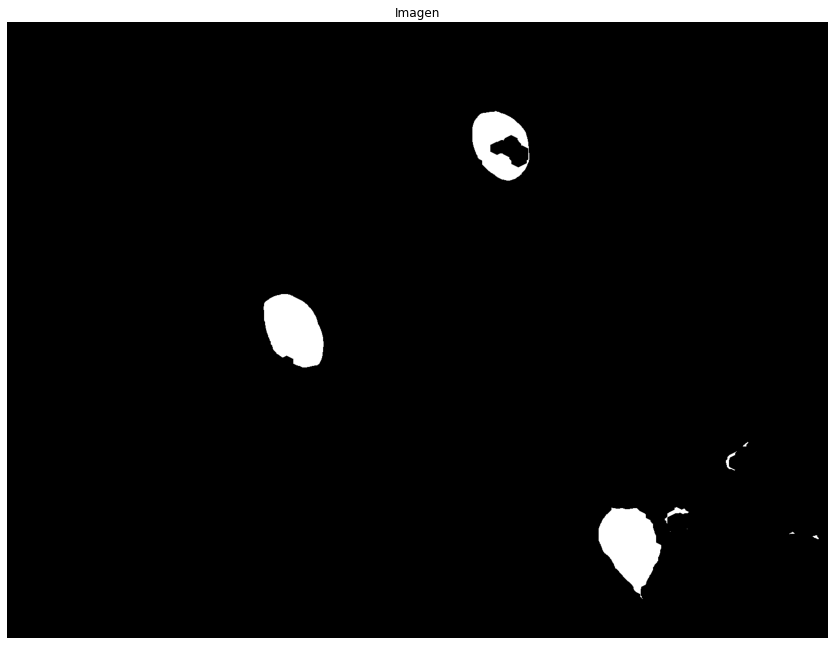

In [175]:
sample_1 = cv2.imread('./sample-1.png')
sample_1 = cv2.cvtColor(sample_1, cv2.COLOR_BGR2RGB)

violet = (205, 116, 220)
darkPurple = (30, 10, 25)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))

infected_cells = color_segmentation(sample_1, violet, darkPurple)
infected_cells = cv2.erode(infected_cells, kernel)
gray_image = cv2.cvtColor(infected_cells, cv2.COLOR_RGB2GRAY)
ret, bin_image = cv2.threshold(gray_image,25,255,cv2.THRESH_BINARY)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
bin_image = cv2.erode(bin_image, kernel, iterations=3)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
close = cv2.morphologyEx(bin_image, cv2.MORPH_CLOSE, kernel, iterations=6)

plot_sample(close)

result_image = np.zeros_like(gray_image)

for y in range(close.shape[0]):
    for x in range(close.shape[1]):
        if close[y, x] > 128:
            result_image[y, x] = gray_image[y, x]

In [174]:
def get_sample_ready(sample):
    violet = (205, 116, 220)
    darkPurple = (30, 10, 25)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))

    infected_cells = color_segmentation(sample_1, violet, darkPurple)
    infected_cells = cv2.erode(infected_cells, kernel)
    gray_image = cv2.cvtColor(infected_cells, cv2.COLOR_RGB2GRAY)
    ret, bin_image = cv2.threshold(gray_image,25,255,cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    bin_image = cv2.erode(bin_image, kernel, iterations=3)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    close = cv2.morphologyEx(bin_image, cv2.MORPH_CLOSE, kernel, iterations=6)

    result_image = np.zeros_like(gray_image)

    for y in range(close.shape[0]):
        for x in range(close.shape[1]):
            if close[y, x] > 128:
                result_image[y, x] = gray_image[y, x]
    
    return result_image.astype(np.float32)

In [196]:
def make_chars_vector(cnt):
    if len(cnt) < 5 :
        return []
    if cnt.dtype != np.float32:
        cnt = cnt.astype(np.float32)
    a = cv2.contourArea(cnt)
    p = cv2.arcLength(cnt, True)
    ((x, y), (w, h), angle) = cv2.minAreaRect(cnt)
    d = w*h
    comp = (p**2)/a
    redon = (4*math.pi*a)/(p**2)
    var = np.var(cnt)
    r = 1 - (1/(1+var**2))
    M = cv2.moments(cnt)
    norm_cent_moms = [M['m00'], M['m01'],  M['m10'], M['m11'], M['m21'], M['m12'], M['m20'], M['m02'], M['m30'], M['m03']]
    spacial_moms = [M['nu20'], M['nu11'],  M['nu02'], M['nu30'], M['nu21'], M['nu12'], M['nu03']]
    Hu = cv2.HuMoments(M)
    hu_moms = np.concatenate((Hu[0], Hu[1], Hu[2], Hu[3], Hu[4], Hu[5], Hu[6]))

    hist, bin_edges = np.histogram(cnt)
    epsilon = 1e-10
    hist_smoothed = hist + epsilon
    u = sum(hist_smoothed**2)
    e = -1*sum(hist_smoothed*np.log2(hist_smoothed))
    
    chars = np.concatenate(([a,p,d,comp,redon,var,r,u,e], norm_cent_moms, spacial_moms, hu_moms))
    return chars

In [176]:
contours, _ = cv2.findContours(result_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [179]:
cnt = contours[1]
make_chars_vector(cnt)

array([ 3.45000000e+01,  2.95563488e+01,  6.59827781e+01,  2.53210943e+01,
        4.96280708e-01,  8.19654219e+04,  1.00000000e+00,  5.12000000e+02,
       -1.28000000e+02,  3.45000000e+01,  3.46031667e+04,  5.43780000e+04,
        5.45406874e+07,  8.59659477e+10,  5.47040007e+10,  8.57093992e+07,
        3.47067301e+07,  1.35093594e+11,  3.48106920e+10,  1.79967672e-01,
        6.61762691e-02,  7.41413815e-02, -1.52824073e-02,  1.11139882e-02,
        1.44169554e-02,  4.48538245e-03,  2.54109054e-01,  2.87163982e-02,
        4.25884645e-03,  2.44089372e-04, -1.45470120e-07, -2.92461958e-05,
       -2.01925219e-07])

In [202]:
original_images = []
contours = []

path = './imgs'
file_list = os.listdir(path)

for filename in file_list:
    # Construir la ruta completa de la imagen
    image_path = os.path.join(path, filename)
    
    # Cargar la imagen
    image = cv2.imread(image_path)

    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_images.append(image)
        adjusted_samples = get_sample_ready(image)
        conts, _ = cv2.findContours(result_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in conts:
            contours.append(cnt)
    else:
        raise ValueError("No se encontró la imagen {}".format(filename))
print('Imágenes ajustadas...')

Imágenes ajustadas...


In [203]:
chars_vectors = []
print(contours)
for cnt in contours:
    c_vector = make_chars_vector(cnt)
    if c_vector != []:
        chars_vectors.append(c_vector)
chars_vectors

[array([[[1234, 1115]],

       [[1234, 1119]],

       [[1238, 1123]],

       [[1236, 1121]],

       [[1236, 1118]],

       [[1235, 1118]],

       [[1234, 1117]]], dtype=int32), array([[[1575, 1000]],

       [[1574, 1001]],

       [[1571, 1001]],

       [[1570, 1002]],

       [[1571, 1002]],

       [[1573, 1004]],

       [[1575, 1004]],

       [[1576, 1005]],

       [[1577, 1005]],

       [[1578, 1006]],

       [[1579, 1006]],

       [[1580, 1007]],

       [[1581, 1006]],

       [[1581, 1005]],

       [[1578, 1002]],

       [[1578, 1000]]], dtype=int32), array([[[1530,  993]],

       [[1528,  995]],

       [[1527,  995]],

       [[1526,  996]],

       [[1525,  996]],

       [[1525,  997]],

       [[1526,  996]],

       [[1534,  996]],

       [[1532,  994]],

       [[1531,  994]]], dtype=int32), array([[[1292,  992]]], dtype=int32), array([[[1325,  987]]], dtype=int32), array([[[1178,  946]],

       [[1178,  950]],

       [[1169,  959]],

       [[1168,  9

ValueError: operands could not be broadcast together with shapes (33,) (0,) 